In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import euclidean, cityblock
import sqlite3
from tkinter import Tk, Label

plt.style.use('ggplot')
%matplotlib inline

In [41]:
con = sqlite3.connect("key.db")
cur = con.cursor()

In [42]:
df = pd.read_sql('SELECT * FROM KeyStrokeDistance', con)
subject = df['subject']
df.head()
df2 = pd.read_sql('SELECT * FROM KeyStrokeDistanceVerification', con)
subject2 = df2['subject']
df2.head()

,subject,key,H,UD,DD
0,lol,t,0.156,0.141,0.297
1,lol,o,0.078,0.500,0.578
2,lol,j,0.094,0.375,0.469
3,lol,j,0.125,0.125,0.250
4,lol,a,0.156,0.328,0.484


In [43]:
class ManhattanDetector:

    def __init__(self, subjects, data, data2):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        self.data = data
        self.data2 = data2
    
    def training(self):
        self.mean_vector = self.train.mean().values  
        
    def evaluateSet1(self):
        eers = []
        for subject in self.subjects:
            genuine_user_data = self.data.loc[self.data.subject == subject, "H" : "DD"]
            genuine_user_data2 = self.data2.loc[self.data.subject == subject, "H" : "DD"]
            imposter_data = self.data.loc[self.data.subject != subject, :]
            #lengthData = int(len(genuine_user_data)*0.7)
            self.train        = genuine_user_data#[:lengthData]
            self.test_genuine = genuine_user_data2#[lengthData+1:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H":"DD"]
            self.training()
            self.testing()
            labels = [0]*len(self.user_scores) + [1]*len(self.imposter_scores)
            fpr, tpr, thresholds = roc_curve(labels, self.user_scores + self.imposter_scores)
        return fpr, tpr, thresholds, self.user_scores
    
    
    
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.train.iloc[i].values)
            self.user_scores.append(cur_score)

        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)

In [44]:
#getting values for Manhattan distance

#data1 = pd.read_csv(DATASET_1)
data1 = df
subjects1 = data1["subject"].unique()
#data2 = pd.read_csv(DATASET_2)
data2 = df2
subjects2 = data2["subject"].unique()



In [45]:
class GUI:
    def __init__(self, master, text):
        self.master = master
        master.title("Weryfikacja")
        self.label = Label(master, text=text, font=('bold', 48), bg='LightSkyBlue3')
        self.label.pack()


In [46]:
fpr1_1, tpr1_1, thresholds1_1, score = ManhattanDetector(subjects1, data1, data2).evaluateSet1()
eer1_1 = brentq(lambda x : 1. - x - interp1d(fpr1_1, tpr1_1)(x), 0., 1.)
points = 0
for elem in score:
    if elem<0.2:
        points+=3
    elif elem>=0.2 and elem<0.4:
        points+=2
    elif elem>=0.4 and elem<0.7:
        points+=1
print(score)
print(points)
print(len(score))

if points>=len(score)*2.25:
    text = "Zweryfikowano\npomyślnie!"
else:
    text = "Negatywna\nweryfikacja!"

root = Tk()
my_gui = GUI(root, text)
root.mainloop()



    

[0.09399999999999999, 0.061999999999999944, 0.596, 0.312, 0.28, 0.75, 0.40800000000000003, 0.6559999999999999, 2.436, 0.0, 1.5939999999999999, 0.032000000000000015, 0.28200000000000003, 0.15599999999999997, 0.28400000000000003, 0.532, 0.188, 0.126]
33
18


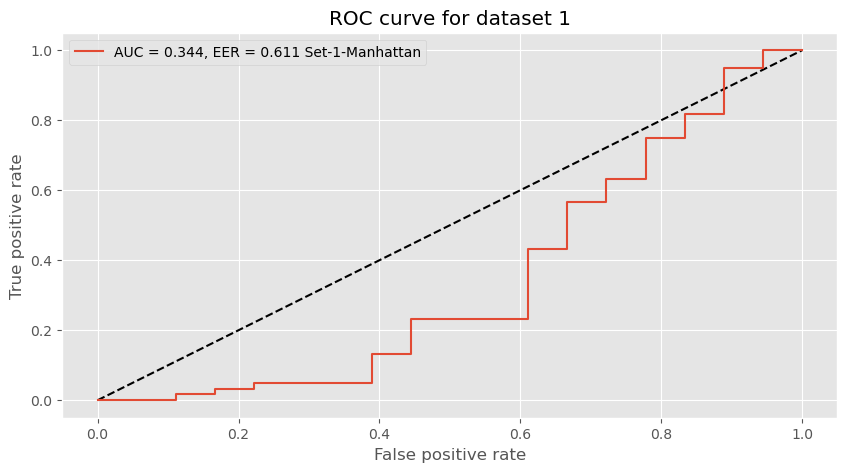

In [47]:
plt.figure(figsize = (10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1_1, tpr1_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-Manhattan'.format(auc(fpr1_1, tpr1_1), eer1_1))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for dataset 1')
plt.legend(loc='best')
plt.show()